In [1]:
# download repo
! git clone https://github.com/MarthyGarcia/IFT6759_B_H23.git
%cd IFT6759_B_H23

# install make
! apt-get install binutils

# run dependencies
! make requirements

! make sync_data

Cloning into 'IFT6759_B_H23'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 375 (delta 92), reused 77 (delta 54), pack-reused 233
Receiving objects: 100% (375/375), 6.57 MiB | 3.38 MiB/s, done.
Resolving deltas: 100% (216/216), done.
Updating files: 100% (47/47), done.
/content/IFT6759_B_H23
Reading package lists... Done
Building dependency tree       
Reading state information... Done
binutils is already the newest version (2.34-6ubuntu1.4).
binutils set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
python3 test_environment.py
>>> Development environment passes all tests!
python3 -m pip install -U pip setuptools wheel
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing 

In [2]:
# https://towardsdatascience.com/darts-swiss-knife-for-time-series-forecasting-in-python-f37bb74c126

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import plotly.express as px
import plotly.graph_objects as go

import pmdarima as pmd
from darts.models.forecasting import auto_arima, varima
from darts import TimeSeries

from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox

from statsmodels.tsa.seasonal import seasonal_decompose

MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

In [3]:
## fit the chosen forecaster model and compute predictions

def eval_model(model, train, val):
    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # compute accuracy metrics and processing time
#     res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_accuracy = {"MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle}

    results = [forecast, res_accuracy]
    return results

In [4]:
# check for seasonality, via ACF
def prep_seasonality(series, ALPHA):
    for m in range(2, 168+1):
        is_seasonal, mseas = check_seasonality(series,m=m, alpha=ALPHA, max_lag=168)
        if is_seasonal:
            break

    print("seasonal? " + str(is_seasonal))
    if is_seasonal:
        print('There is seasonality of order {}.'.format(mseas))

    split_at = TRAIN
    train, val = series.split_before(split_at)

    plt.figure(101, figsize=(12, 5))
    train.plot(label='training')
    val.plot(label='validation')
    plt.legend();
    
    return is_seasonal, mseas, train, val

In [5]:
def prep_ARIMA(series, ALPHA, mseas, is_seasonal):
    # prepare ARIMA forecaster
    y = np.asarray(series.pd_series())
    # get order of first differencing: the higher of KPSS and ADF test results
    n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
    n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
    n_diff = max(n_adf, n_kpss)

    # get order of seasonal differencing: the higher of OCSB and CH test results
    n_ocsb = pmd.arima.OCSBTest(m=max(168,mseas)).estimate_seasonal_differencing_term(y)
    n_ch = pmd.arima.CHTest(m=max(168,mseas)).estimate_seasonal_differencing_term(y)
    ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

    # set up the ARIMA forecaster
    model = auto_arima.AutoARIMA(
        start_p=2, d=n_diff, start_q=2,
        max_p=4, max_d=n_diff, max_q=4,
        start_P=2, D=ns_diff, start_Q=2, m=max(4,mseas), seasonal=is_seasonal,
        max_P=3, max_D=1, max_Q=3,
        max_order=5,                       # p+q+p+Q <= max_order
        stationary=False, 
        information_criterion="bic", alpha=ALPHA, 
        test="kpss", seasonal_test="ocsb",
        stepwise=True, 
        suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")
    
    return model

In [6]:
def plot(series, predictions, title):
    df = series.pd_dataframe()
    p = series.pd_series()
    p.update(predictions[0].pd_series())
    df[1] = p
    
    df = df.rename(columns={0:"Actual", 1:"Predicted"})
    fig = px.line(df, title=title)
    return fig

In [10]:
!ls data/raw/crypto

AAPL.csv  BAC.csv  ETH.csv  HD.csv   MS.csv    TD.csv	 WMT.csv
AMC.csv   BTC.csv  GME.csv  JPM.csv  MSFT.csv  TSLA.csv


seasonal? False


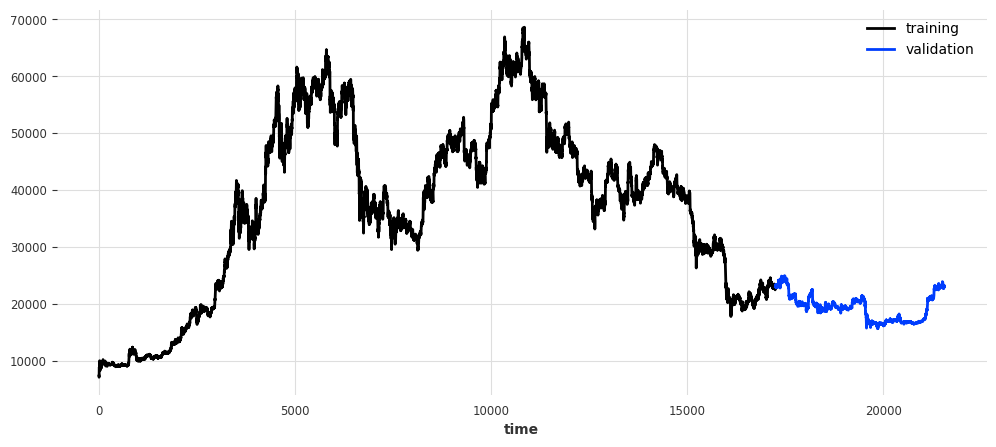

In [23]:
# df = pd.read_csv("../exchange_rate/exchange_rate.txt", header=None)
# df = pd.read_csv("../electricity/electricity.txt", header=None)
# df = pd.read_csv("../solar-energy/solar_AL.txt", header=None)
df = pd.read_csv("data/raw/crypto/BTC.csv", header=None)
series = TimeSeries.from_series(df[0])
TRAIN = int(len(df)*.8)

is_seasonal, mseas, train, val = prep_seasonality(series, ALPHA)

model = prep_ARIMA(series, ALPHA, mseas, is_seasonal)

In [24]:
predictions = eval_model(model, train, val)

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (4) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=249259.585, Time=12.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=249237.832, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=249246.575, Time=1.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=249246.533, Time=2.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=249228.204, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=249256.824, Time=4.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 22.881 seconds


In [25]:
fig = plot(series, predictions, "")

In [26]:
fig.update_layout(template="none")

In [27]:
predictions[1]

{'MAE': 3681.0884972170684,
 'R squared': 2.338670195045763,
 'RMSE': 4212.926793490138,
 'RMSLE': 0.21012915403105903}